## MPAA rating prediction

In [1]:
import pandas as pd
import numpy as np
import warnings
import re
import pickle
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

Import dataset :: using the rotten tomatoes dataset

In [2]:
dataset_df = pd.read_csv( './rtt_dataset/all_movie.csv' )
dataset_df = dataset_df[['Title', 'Rating', 'Description']]
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.head(4)

,Title,Rating,Description
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ..."
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...


In [3]:
# finding unique mpaa rating in the dataset
dataset_df['Rating'].unique()

array(['PG-13 ', 'PG-13', 'R ', 'NR', 'PG', 'G', 'PG ', 'R', 'G ', 'NR ',
       'NC17', 'NC17 '], dtype=object)

In [4]:
# clean mpaa ratings
mpaa_fix = {
    'PG-13 ' : 'PG-13',
    'R ' : 'R',
    'PG ': 'PG',
    'G ' : 'G',
    'NR ': 'NR',
    'NC17 ': 'NC17'
}
for i, rating in dataset_df['Rating'].iteritems():
    if rating in mpaa_fix.keys():
        fix_val = mpaa_fix.get(rating)
        dataset_df.iloc[i]['Rating'] = fix_val

In [5]:
# Clean the movie description
def clean_description( text_str ):
    text = re.sub('[^a-zA-Z]',  ' ', text_str)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

cleaned_desc = []
for i, description in dataset_df['Description'].iteritems():
    cleaned_desc.append( clean_description( str(description) ) )

dataset_df['cleanedDescr'] = cleaned_desc
dataset_df.head(4)

,Title,Rating,Description,cleanedDescr
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...,The journey of professional wrestler who becom...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ...",Dead pan Leslie Nielsen stars as Dick Steele a...
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...,Director Uli Edel teams with screenwriter Bern...


In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29810 entries, 0 to 29809
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         29810 non-null  object
 1   Rating        29810 non-null  object
 2   Description   29807 non-null  object
 3   cleanedDescr  29810 non-null  object
dtypes: object(4)
memory usage: 931.7+ KB


In [7]:
## drop G, NC-17
dataset_df = dataset_df[dataset_df.Rating != 'NC17']

In [8]:
pickle.dump(dataset_df, open('./data/demo_cp_dataset2.pkl', 'wb'))

### Further clean the description

## Training model

In [9]:
# training_df = pickle.load( open('./data/dataset_df_cleaned_n_sample_exceptNC17BiD_cleaned.pkl', 'rb') )
training_df = pickle.load( open('./data/demo_cp_dataset2.pkl', 'rb') )

In [10]:
# fig = plt.figure(figsize=(8,6))
# dataset_df.groupby('Rating')['cleanedDescr'].count().plot.bar(ylim=0)
# plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D, Bidirectional, Dropout, BatchNormalization
from keras import regularizers

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [12]:
_y = training_df['Rating']
encoder = LabelEncoder()
Y = encoder.fit_transform(_y)
Y

array([3, 3, 3, ..., 4, 3, 3])

In [13]:
le = encoder.fit(_y)
labels = list(le.classes_)
labels

['G', 'NR', 'PG', 'PG-13', 'R']

In [14]:
X = training_df['cleanedDescr']
X

0        The Fast and the Furious director Rob Cohen co...
1        The journey of professional wrestler who becom...
2        Dead pan Leslie Nielsen stars as Dick Steele a...
3        Director Uli Edel teams with screenwriter Bern...
4        One of cluster of late films about the Vietnam...
                               ...                        
29805    Filmed at least nine times over the last nine ...
29806    Fred MacMurray stars in this Walt Disney comed...
29807    A resident of rd century Earth becomes involve...
29808    Supernova chronicles the search and rescue pat...
29809    For years there have been documented cases of ...
Name: cleanedDescr, Length: 29719, dtype: object

In [15]:
description_lengths = []
for i, description in training_df['cleanedDescr'].iteritems():
    description_lengths.append( len(description) )
max_description_length = np.mean( description_lengths )
max_description_length

729.3011877923215

## Train, test split

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25, random_state=40 )

In [17]:
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)

In [18]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [19]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [20]:
vocabulary_size = len(tokenizer.word_index) + 1
vocabulary_size

57392

In [21]:
maxlen =  400 # Only concider first 400 words of each description

X_train = pad_sequences( X_train, maxlen=maxlen )
X_test  = pad_sequences( X_test, maxlen=maxlen )

## Use GloVe : Global Vectors for Word Representation
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [22]:
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding='utf8')

In [23]:
embedd_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dims = np.asarray(records[1:], dtype='float32')
    embedd_dictionary[word] = vector_dims

glove_file.close()

In [24]:
embedd_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    embedd_vector = embedd_dictionary.get(word)
    if embedd_vector is not None:
        embedd_matrix[index] = embedd_vector
embedd_matrix.shape

(57392, 100)

In [25]:
output_dim = embedd_matrix.shape[1]
output_dim

100

In [26]:
num_labels = 5
G_count = training_df[training_df.Rating=='G'].shape[0]
print("G", G_count)

NR_count = training_df[training_df.Rating=='NR'].shape[0]
print("NR", NR_count)


PG_count = training_df[training_df.Rating=='PG'].shape[0]
print("PG", PG_count)


PG13_count = training_df[training_df.Rating=='PG-13'].shape[0]
print("PG13", PG13_count)


R_count = training_df[training_df.Rating=='R'].shape[0]
print("R", R_count)

G 1606
NR 8005
PG 4172
PG13 5052
R 10884


In [27]:
total_count = training_df.shape[0]
total_count

29719

In [28]:
weight_G = ( 1 / G_count ) * ( total_count ) / num_labels
weight_NR = ( 1 / NR_count ) * ( total_count ) / num_labels
weight_PG = ( 1 / PG_count ) * ( total_count ) / num_labels
weight_PG13 = ( 1 / PG13_count ) * ( total_count ) / num_labels
weight_R = ( 1 / R_count ) * ( total_count ) / num_labels

In [29]:
class_weight = {0:weight_G ,1:weight_NR ,2: weight_PG,3:weight_PG13,4:weight_R}
class_weight

{0: 3.7009962640099623,
 1: 0.7425109306683323,
 2: 1.4246883988494727,
 3: 1.1765241488519398,
 4: 0.5461043733921354}

## Build the NN Model

In [50]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=output_dim, weights=[embedd_matrix], trainable=False))
model.add( Bidirectional(LSTM(units=128, recurrent_dropout=0)) )
model.add(Dropout(0.4))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         5739200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 5,990,469
Trainable params: 251,269
Non-trainable params: 5,739,200
______________________________________

In [51]:
import keras
callback = [
    keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', verbose=2),
    keras.callbacks.ModelCheckpoint(filepath='./data/checkpoint/BDLSTM2_demo.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True ),
    keras.callbacks.TensorBoard(log_dir='./data/tf/logs'),
]

In [52]:
hist = model.fit(X_train, Y_train, batch_size=64, epochs=120, validation_data=(X_test, Y_test), verbose=1, class_weight=class_weight, callbacks=callback)

Epoch 1/120
349/349 [==============================] - 23s 62ms/step - loss: 1.6558 - accuracy: 0.2443 - val_loss: 1.5052 - val_accuracy: 0.3342
Epoch 2/120
349/349 [==============================] - 20s 57ms/step - loss: 1.4653 - accuracy: 0.3474 - val_loss: 1.4115 - val_accuracy: 0.4096
Epoch 3/120
349/349 [==============================] - 20s 58ms/step - loss: 1.3521 - accuracy: 0.4089 - val_loss: 1.3600 - val_accuracy: 0.4371
Epoch 4/120
349/349 [==============================] - 20s 58ms/step - loss: 1.2926 - accuracy: 0.4415 - val_loss: 1.2591 - val_accuracy: 0.4653
Epoch 5/120
349/349 [==============================] - 20s 58ms/step - loss: 1.2238 - accuracy: 0.4612 - val_loss: 1.2079 - val_accuracy: 0.4980
Epoch 6/120
349/349 [==============================] - 20s 58ms/step - loss: 1.1137 - accuracy: 0.4975 - val_loss: 1.2269 - val_accuracy: 0.4787
Epoch 7/120
349/349 [==============================] - 20s 58ms/step - loss: 1.0121 - accuracy: 0.5306 - val_loss: 1.1472 - val_ac

In [53]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

233/233 [==============================] - 5s 21ms/step - loss: 1.0125 - accuracy: 0.7575
loss:  1.0124573707580566
accuracy:  0.7574697136878967


## Save model and tokenizer

In [54]:
# save model
model.save('./data/demo_bltsm_model2.h5')

# save word tokenizer
pickle.dump(tokenizer, open('./data/demo_cp_tokenizer2.pkl', 'wb'))

## Model Architecture

In [55]:
# load the saved model
from keras.models import load_model
model = load_model("./data/demo_bltsm_model2.h5")

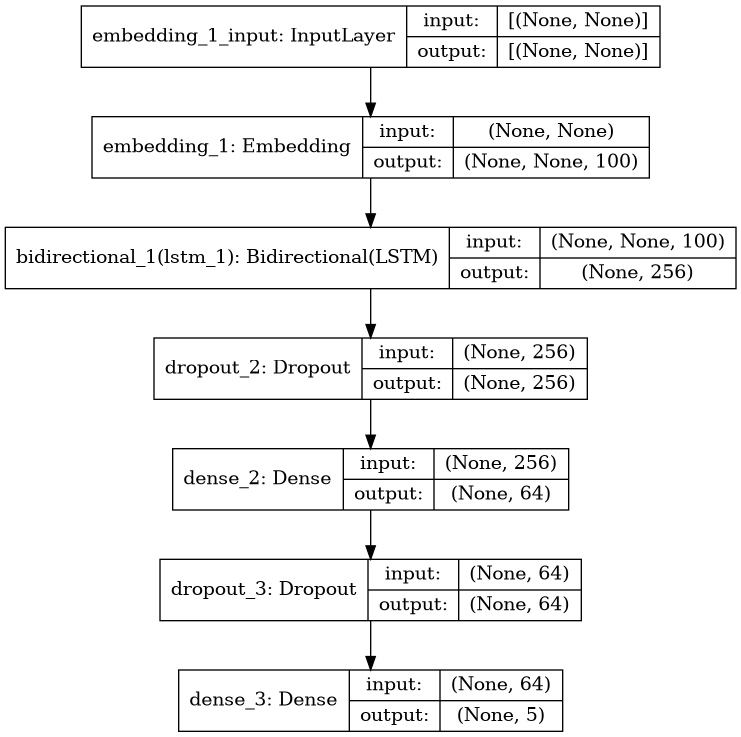

In [56]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Metrics

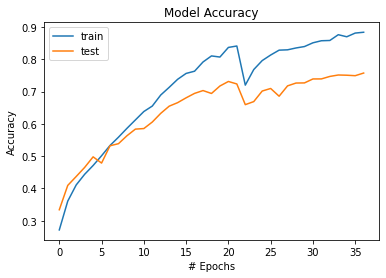

In [57]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

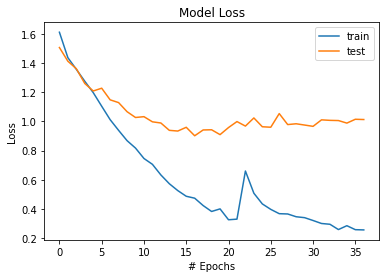

In [58]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

### Label maps

In [59]:
le = encoder.fit(_y)
labels = list(le.classes_)
labels

['G', 'NR', 'PG', 'PG-13', 'R']

In [60]:
class_names = dict(zip(le.classes_, le.transform(le.classes_)))
class_names

{'G': 0, 'NR': 1, 'PG': 2, 'PG-13': 3, 'R': 4}

In [61]:
Y_pred = model.predict(X_test)

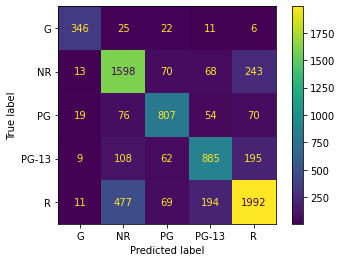

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1) )
cmd = ConfusionMatrixDisplay(cm, display_labels=list(le.classes_))
cmd.plot()

In [63]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(Y_pred, axis=1)

print(classification_report(Y_test.argmax(axis=1), y_pred_bool))


117/117 [==============================] - 3s 24ms/step
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       410
           1       0.70      0.80      0.75      1992
           2       0.78      0.79      0.79      1026
           3       0.73      0.70      0.72      1259
           4       0.79      0.73      0.76      2743

    accuracy                           0.76      7430
   macro avg       0.78      0.77      0.77      7430
weighted avg       0.76      0.76      0.76      7430



---

## Demonstration

In [64]:
import pickle
from keras.models import Sequential, load_model
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

In [65]:
## Get tokenizer 
text_tokenizer = pickle.load(open('./data/demo_cp_tokenizer2.pkl', 'rb'))
## Get saved model
saved_model = load_model("./data/demo_bltsm_model2.h5")

## prepare class names
mpaa_labels = {0 : 'G', 1: 'NR', 2: 'PG', 3: 'PG-13', 4 : 'R'}

## max length allowed for texts
max_text_len= 420

In [66]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
history = []

In [67]:
textarea = widgets.Textarea(
    value='',
    placeholder='Enter movie synopsis',
    description='Synopsis:',
    disabled=False,
    width=600
)

In [68]:
def make_prediction(b):
    val = textarea.value
    if val is not None:
        synopsisTKN = text_tokenizer.texts_to_sequences(val)
        #print("TOKENIZATION=", synopsisTKN)
        
        text_list = []
        for sub_list in synopsisTKN:
            for tm in sub_list:
                text_list.append(tm)
             
        # add padding
        synopsis = pad_sequences([text_list], maxlen=max_text_len)
        #print(synopsis)
        
        # make prediction
        pred = saved_model.predict_classes(synopsis)
        _class_lable = mpaa_labels[pred[0]]
        
        record = {
            "label" : _class_lable,
            "synopsis" : val
        }
        
        print(record)

In [69]:
submit = widgets.Button(description='Submit')
submit.on_click(make_prediction)
widgets.VBox([textarea,submit])